In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd




In [2]:
df = pd.read_csv('SIR.csv')

In [3]:
df

_id  casConfirmes    deces   gueris        date
0    5f3b06e8e9b9e05e83a3d671         191.0      3.0      NaN  2020-03-02
1    5f3b06e8e9b9e05e83a3d672         212.0      4.0     12.0  2020-03-03
2    5f3b06e8e9b9e05e83a3d673         285.0      4.0      NaN  2020-03-04
3    5f3b06e8e9b9e05e83a3d674         423.0      7.0      NaN  2020-03-05
4    5f3b06e8e9b9e05e83a3d675         613.0      9.0      NaN  2020-03-06
..                        ...           ...      ...      ...         ...
164  5f3b06e8e9b9e05e83a3d715      209365.0  19883.0  83663.0  2020-08-13
165  5f3b06e8e9b9e05e83a3d716      212211.0  19901.0  83848.0  2020-08-14
166  5f3b06e8e9b9e05e83a3d717      215521.0  19904.0      NaN  2020-08-15
167  5f3b06e8e9b9e05e83a3d718      218536.0      NaN      NaN  2020-08-16
168  5f3b06e8e9b9e05e83a3d719      219029.0  19924.0  84065.0  2020-08-17

[169 rows x 5 columns]

In [18]:
 df1 = df.drop('_id', axis =1)

In [20]:
df2 = df2.rename(columns={'casConfirmes': 'infectious','deces': 'dead' ,'gueris': 'recovered'})

In [34]:
df2.dropna()

infectious     dead  recovered        date
1         212.0      4.0       12.0  2020-03-03
15       7730.0    175.0      602.0  2020-03-17
16       9134.0    264.0     1000.0  2020-03-18
17      10995.0    372.0     1300.0  2020-03-19
18      12612.0    450.0     1587.0  2020-03-20
..          ...      ...        ...         ...
162    204172.0  19849.0    83237.0  2020-08-11
163    206696.0  19866.0    83472.0  2020-08-12
164    209365.0  19883.0    83663.0  2020-08-13
165    212211.0  19901.0    83848.0  2020-08-14
168    219029.0  19924.0    84065.0  2020-08-17

[140 rows x 4 columns]

In [35]:
### FUNCTIONS LIVE UP HERE ###

def plot_sir(time_grid, susceptible, infectious, recovered):
    '''
    Plotting function for SIR model
    '''
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
    
    ax.plot(time_grid, susceptible, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(time_grid, infectious, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(time_grid, recovered, 'g', alpha=0.5, lw=2, label='Recovered')

    ax.set_xlabel('days')
    ax.set_ylabel('Number People')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()


def get_initial_susceptible(total_population, initial_infected, initial_recovered):
    '''
    Everyone not initially_infected is naively
    considered susceptible initially
    '''
    return total_population - initial_infected - initial_recovered

def get_beta(avg_num_contacts_per_person, proba_of_disease_transm):
    '''
    beta is the avg number of contacts per person,
    per day, multiplied by the proba of disease transm
    in a contact between a susceptible preson and 
    an infectious person
    susceptible --> infectious
    '''
    return avg_num_contacts_per_person * proba_of_disease_transm


def get_mean_recov_rate(recovery_period_in_days):
    '''
    mean recovery/mortality rate (gamma), 1 over how many
    days it takes a person to recover
    '''
    return 1.0 / recovery_period_in_days


def deriv_susceptible_wrt_time(beta, susceptible, infectious, total_population):
    '''
    assume that susceptible will always decrease given
    the nature of this disease transm e.g. assumed immunity
    '''
    return -beta * susceptible * (infectious / total_population)


def deriv_infectious_wrt_time(beta, susceptible, infectious, total_population, mean_recov_rate):
    '''
    simply, infectious draws from susceptible, and is depleted by recovery
    '''
    return beta * susceptible * (infectious / total_population) - (mean_recov_rate * infectious)


def deriv_recovered_wrt_time(mean_recov_rate, infectious):
    '''
    assume that recovered is not again susceptible, draws from infectious
    Challenge: incorporate a rate of becoming susceptible again, or reflect partial immunity
    '''
    return mean_recov_rate * infectious


def derivatives_helper(initial_conditions, time_grid, total_population, beta, mean_recov_rate):
    '''
    facilitates the odeint solver from scipy
    notes: time_grid param is not explicitly use
           initial recov'd value is not explicitly used
           from initial_conditions
    '''
    susceptible, infectious, _ = initial_conditions

    dSdt = deriv_susceptible_wrt_time(beta, susceptible, infectious, total_population)
    dIdt = deriv_infectious_wrt_time(beta, susceptible, infectious, total_population, mean_recov_rate)
    dRdt = deriv_recovered_wrt_time(mean_recov_rate, infectious)

    return dSdt, dIdt, dRdt


def driver(total_population, days, initial_infected, recovery_period_in_days, avg_num_contacts_per_person, proba_of_disease_transm):
    ### THIS IS OUR PROCEDURE ###
    # simply the total population minus the initial infected and initial recovered
    initial_susceptible = get_initial_susceptible(total_population, initial_infected, initial_recovered)


    # transm rate from susceptible to infectious
    beta = get_beta(avg_num_contacts_per_person, proba_of_disease_transm)


    # gamma, mean transmission rate from infectious to recovered
    mean_recov_rate = get_mean_recov_rate(recovery_period_in_days)


    # each derivative is a funct of time, so we set up a numpy array for time that we'll use in calc's and plotting
    time_grid = np.linspace(0, days, days)

    # Set initial conditions for our diffEQ solver
    initial_conditions = (initial_susceptible, initial_infected, initial_recovered)

    # Integrate the SIR equations over the time grid (in days)
    integrate_functions = odeint(derivatives_helper, initial_conditions, time_grid, args=(total_population, beta, mean_recov_rate))

    # unpack the values iot pass them into a plotting function
    susceptible, infectious, recovered = integrate_functions.T
    
    plot_sir(time_grid, susceptible, infectious, recovered)


if __name__ == "__main__":
    ### THESE ARE OUR PARAMETERS ###



    # Assume a "closed" population (related to S)
    total_population = 67000000

    # TODO: add param for population density?

    # Number of days in consideration
    days = 140

    initial_infected = 191
    initial_recovered = 0

    # parameter to build avg recovery rate (gamma)
    recovery_period_in_days = 10

    # params to build beta, our transmission rate from susceptible to infectious
    avg_num_contacts_per_person = 5 # per day
    proba_of_disease_transm = 0.04 # of acquiring the disease AND encountering a person with the disease
    
    # TODO: percentage of infected who need hospitalization


    # Run the model
    driver(total_population, days, initial_infected, recovery_period_in_days, avg_num_contacts_per_person, proba_of_disease_transm)


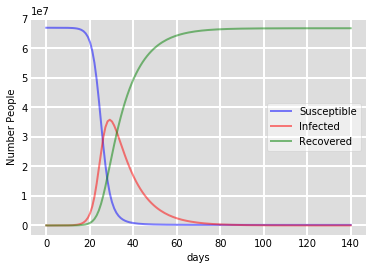

In [37]:
# build paramters taking in consideration no social distanciating and no lockdown, which will have a probability of 
#transmission higher 


# params to build beta, our transmission rate from susceptible to infectious
avg_num_contacts_per_person = 15 # per day
roba_of_disease_transm = 0.08 # of acquiring the disease AND encountering a person with the disease
    
    # TODO: percentage of infected who need hospitalization


    # Run the model
driver(total_population, days, initial_infected, recovery_period_in_days, avg_num_contacts_per_person, proba_of_disease_transm)
